In [1]:
import dask
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from datetime import datetime
from matplotlib.ticker import FormatStrFormatter

dask.config.set(scheduler = "single-threaded")

In [2]:
# Load data sets
# --------------------------------------

ds1 = xr.open_mfdataset('/Users/smata/Downloads/processedData/sgpco2flx60mC1.b1.*.nc',    combine = 'by_coords', parallel = True)
ds2 = xr.open_mfdataset('/Users/smata/Downloads/processedData/sgpaeriprof3feltzC1.*.cdf', combine = 'by_coords', parallel = True)

In [3]:
# Get reference dates from each data set
# --------------------------------------

ref_date1 = np.datetime64(datetime(pd.to_datetime(ds1.time[0].values).year, pd.to_datetime(ds1.time[0].values).month, pd.to_datetime(ds1.time[0].values).day))
ref_date2 = np.datetime64(datetime(pd.to_datetime(ds2.time[0].values).year, pd.to_datetime(ds2.time[0].values).month, pd.to_datetime(ds2.time[0].values).day))

In [4]:
# Ensure reference dates match
# --------------------------------------

assert(ref_date1 == ref_date2)

In [5]:
# Compute new time axis
# --------------------------------------

ds1['time'] = ((ds1.time - ref_date1) / np.timedelta64(1, 'D')).values
ds2['time'] = ((ds2.time - ref_date2) / np.timedelta64(1, 'D')).values

In [6]:
# Get interpolation values
# --------------------------------------

min_date = max([ds1['time'][0],  ds2['time'][0]])
max_date = min([ds1['time'][-1], ds2['time'][-1]])

interval = (1 / 12) / 24

common_time = np.arange(min_date, max_date, interval)

In [7]:
# Regularize data sets in time
# --------------------------------------

ds1 = ds1.interp(time = common_time)
ds2 = ds2.interp(time = common_time)

ds_combined = xr.merge([ds1, ds2])

In [8]:
# Regularize data sets in space
# --------------------------------------

old_t = ds_combined['virPoTemp'].values

# heights     = np.concatenate(([4], [10], np.arange(20, 2000 + 20, 20)))
heights     = ds_combined['height'].values

# old_heights = ds_combined['height'].values
new_t       = np.zeros((len(heights), ds_combined['virPoTemp'].shape[1]))

# Interpolate to regularized heights
# for t in range(new_t.shape[1]):
#     inds = ~np.isnan(old_t[:, t])
#     if any(inds == True):
#         new_t[:,t] = np.interp(heights, old_heights[inds], old_t[inds, t])

qc_flag_t = np.zeros(common_time.shape)
qc_flag_s = np.zeros(common_time.shape)

total_h = len(heights)

surface_quantity = ds_combined.L.values

# Count nans in each data set
for t in range(common_time.shape[0]):
    qc_flag_t[t] = np.sum(np.isnan(old_t[:, t])) / total_h
    qc_flag_s[t] = ~np.isnan(surface_quantity[t])

# Nan threshold for spatial data
qc_flag_w = qc_flag_t < 2 / 3

qc_flag = qc_flag_w * (qc_flag_s).astype(bool)

del ds1
del ds2

# Store QC'ed data in new structure
ds_new = xr.Dataset({
't': xr.DataArray(
            data   = new_t[:, qc_flag],
            dims   = ['height', 'time'],
            coords = {'height': heights, 'time': common_time[qc_flag]},
),
'L': xr.DataArray(
            data   = 1 / (ds_combined.L.values)[qc_flag],
            dims   = ['time'],
            coords = {'time': common_time[qc_flag]},
),
'TKE': xr.DataArray(
            data   = (ds_combined.TKE.values)[qc_flag],
            dims   = ['time'],
            coords = {'time': common_time[qc_flag]},
),
'hFlux': xr.DataArray(
            data   = (ds_combined.sh_flux.values)[qc_flag],
            dims   = ['time'],
            coords = {'time': common_time[qc_flag]},
),
'mFlux': xr.DataArray(
            data   = (ds_combined.mom_flux.values)[qc_flag],
            dims   = ['time'],
            coords = {'time': common_time[qc_flag]},
),
    })

# Average over 30min windows

ds_new = ds_new.assign_coords(time = pd.Timestamp(ref_date1) + pd.to_timedelta(ds_new.time, unit = 'D').round('min'))

ds_new = ds_new.resample(time = '30min').mean(dim = ['time'])

ds_new['time'] = ((ds_new.time - ref_date1) / np.timedelta64(1, 'D')).values

ds_new = ds_new.dropna(dim = 'time', how = 'all')

ds_new = ds_new.transpose()

del ds_combined

In [10]:
common_time.shape

(347034,)

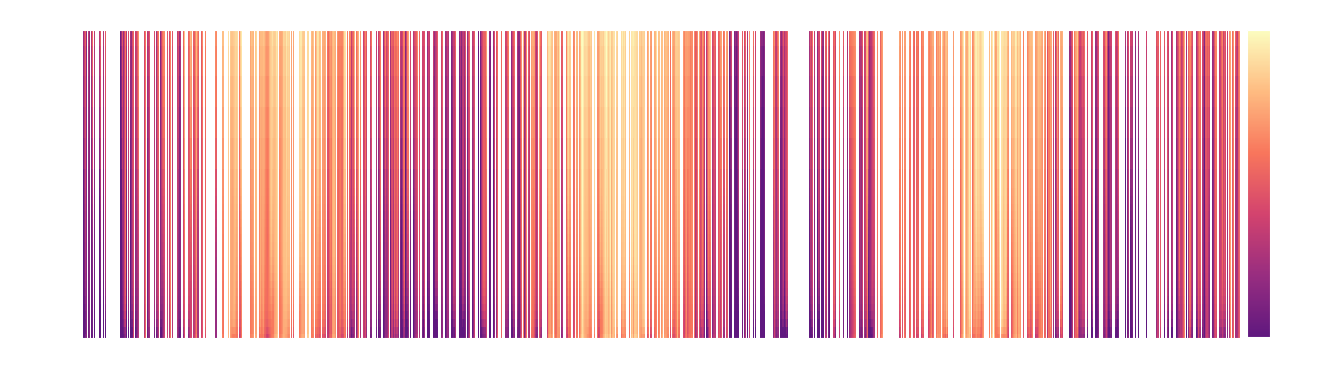

In [97]:
# Plot time-varying profiles
# --------------------------------------

fig,ax = plt.subplots(figsize = (15, 4))

cntf = ax.pcolormesh(common_time, old_heights, old_t, vmin = 280, vmax = 320, cmap = sb.color_palette("blend:#5f187f,#982d80,#d3436e,#f8765c,#febb81,#fcfdbf", as_cmap = True))
ax.set_ylabel("$z$ [m]", color = 'w')
ax.set_ylim([0, 2000])

cb_ax = fig.add_axes([0.905, 0.1125, 0.015, 0.768])
cbar = fig.colorbar(cntf, orientation='vertical', cax = cb_ax)
cbar.set_label('Virtual potential temperature [K]', rotation = 270, labelpad = 15, color = 'w')
cbar.outline.set_color('white')
cbar.ax.yaxis.set_tick_params(color = 'w')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color = 'w')

for spine in ax.spines.values():
    spine.set_edgecolor('w')

ax.set_xticks([0, 360, 725, 1090], ["2021", "2022", "2023", "2024"])
ax.set_title(f'Profiles: {common_time.shape[0]:,}', color = 'w')

ax.tick_params(axis = 'x', colors = 'w')
ax.tick_params(axis = 'y', colors = 'w')

plt.savefig('./temp_timeseries.png', dpi = 500, bbox_inches = 'tight', transparent = True)

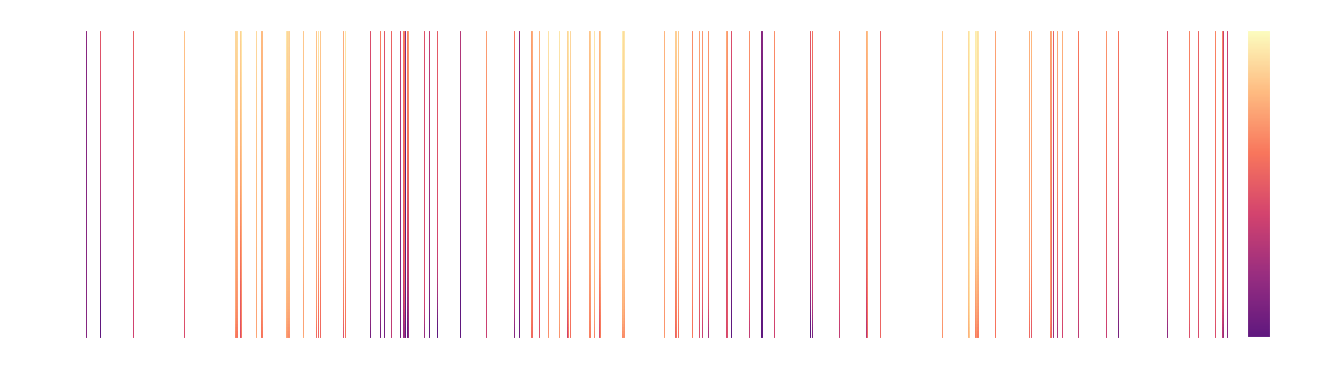

In [98]:
# Plot time-varying profiles
# --------------------------------------

fig,ax = plt.subplots(figsize = (15, 4))

data = new_t

data[:, ~qc_flag] = np.nan

cntf = ax.pcolormesh(common_time, heights, data, vmin = 280, vmax = 320, cmap = sb.color_palette("blend:#5f187f,#982d80,#d3436e,#f8765c,#febb81,#fcfdbf", as_cmap = True))
ax.set_ylabel("$z$ [m]", color = 'w')
ax.set_ylim([0, 2000])

cb_ax = fig.add_axes([0.905, 0.1125, 0.015, 0.768])
cbar = fig.colorbar(cntf, orientation = 'vertical', cax = cb_ax)
cbar.set_label('Virtual potential temperature [K]', rotation = 270, labelpad = 15, color = 'w')
cbar.outline.set_color('white')
cbar.ax.yaxis.set_tick_params(color = 'w')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color = 'w')

for spine in ax.spines.values():
    spine.set_edgecolor('w')

ax.set_xticks([0, 360, 725, 1090], ["2021", "2022", "2023", "2024"])
ax.set_title(f'Profiles: {np.sum(qc_flag):,}', color = 'w')

ax.tick_params(axis = 'x', colors = 'w')
ax.tick_params(axis = 'y', colors = 'w')

plt.savefig('./qc_temp_timeseries.png', dpi = 700, bbox_inches = 'tight', transparent = True)

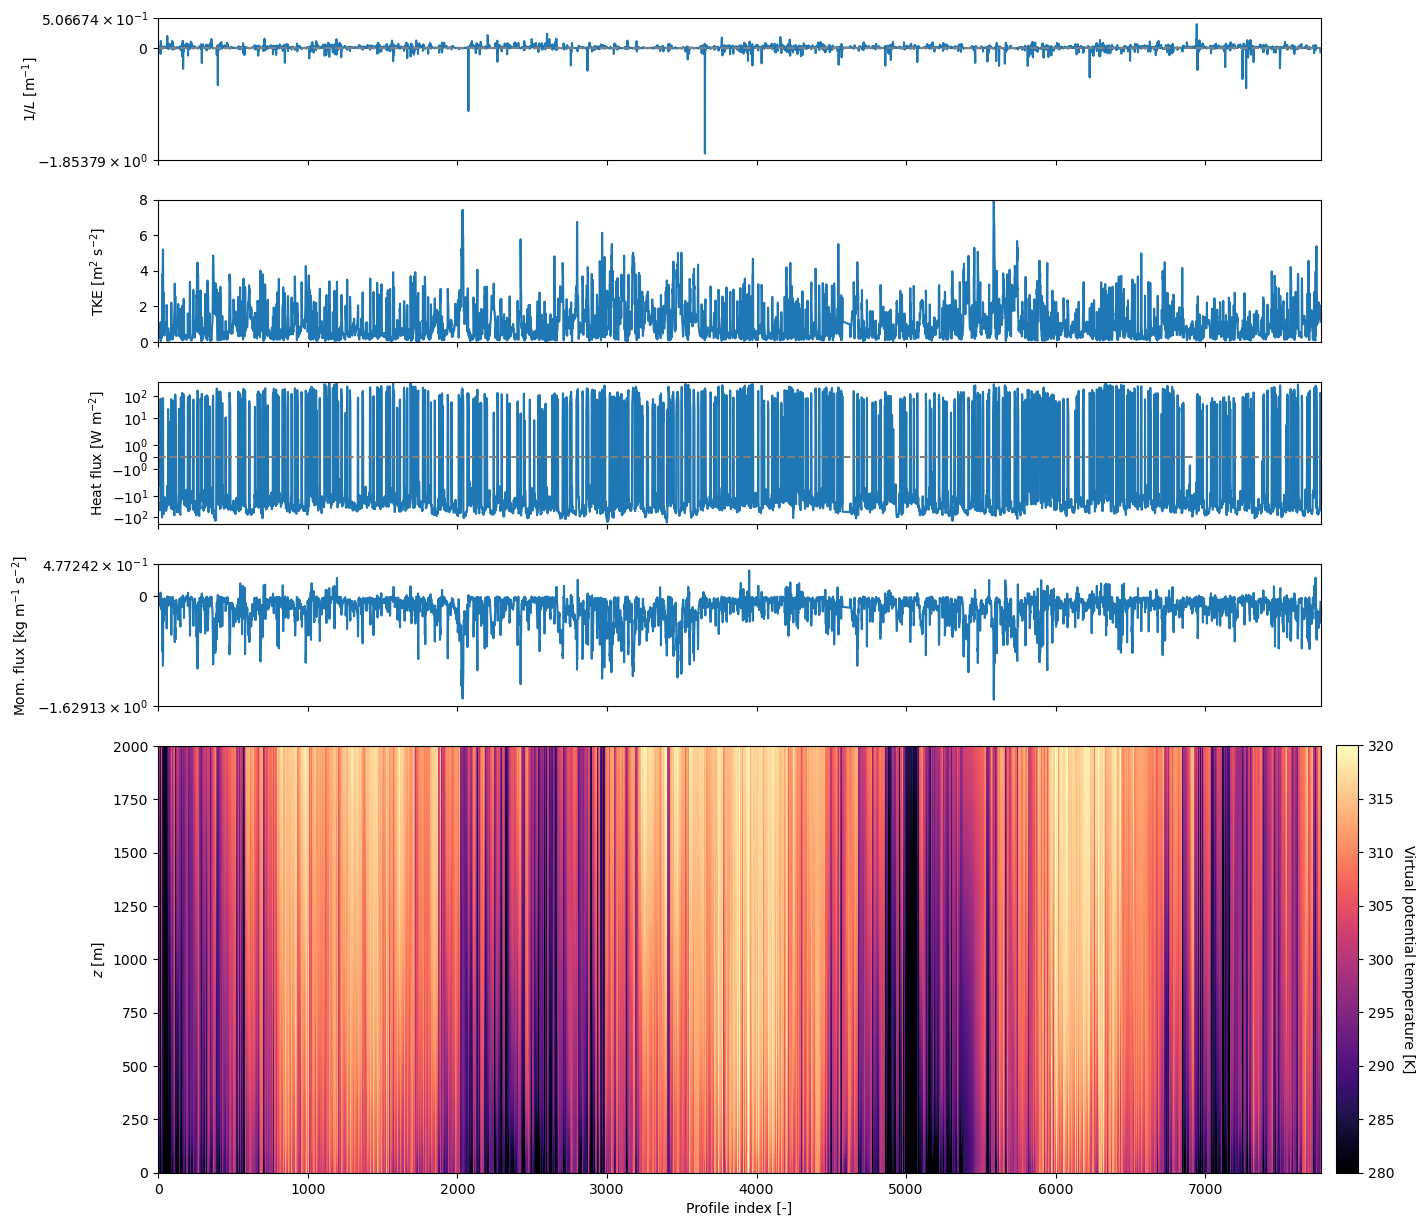

In [25]:
# Plot rectified surface quantities
# --------------------------------------

fig,ax = plt.subplots(5, 1, figsize = (15, 15), gridspec_kw = {'height_ratios': [1, 1, 1, 1, 3]}, sharex = True)

ax[0].plot(range(len(ds_new.time)), ds_new.L)
ax[0].set_ylabel("$1/L$ [m$^{-1}$]", labelpad = -2)
ax[0].axhline(y = 0, color = 'grey', linestyle = '--')
ax[0].set_yscale('symlog')

ax[1].plot(range(len(ds_new.time)), ds_new.TKE)
ax[1].set_ylabel("TKE [m$^2$ s$^{-2}$]", labelpad = 23)
ax[1].set_ylim([0, 8])

ax[2].plot(range(len(ds_new.time)), ds_new.hFlux)
ax[2].set_ylabel("Heat flux [W m$^{-2}$]", labelpad = 3)
ax[2].axhline(y = 0, color = 'grey', linestyle = '--')
ax[2].set_yscale('symlog')

ax[3].plot(range(len(ds_new.time)), ds_new.mFlux)
ax[3].set_ylabel("Mom. flux [kg m$^{-1}$ s$^{-2}$]", labelpad = 4)
ax[3].set_yscale('symlog')

cntf = ax[4].pcolormesh(range(len(ds_new.time)), ds_new.height, ds_new.t, vmin = 280, vmax = 320, cmap = 'magma')
ax[4].set_xlabel("Profile index [-]")
ax[4].set_ylabel("$z$ [m]", labelpad = 4)
ax[4].set_ylim([0, 2000])

cb_ax = fig.add_axes([0.91, 0.11, 0.015, 0.285])
cbar = fig.colorbar(cntf, orientation = 'vertical', cax = cb_ax)
cbar.set_label('Virtual potential temperature [K]', rotation = 270, labelpad = 15)

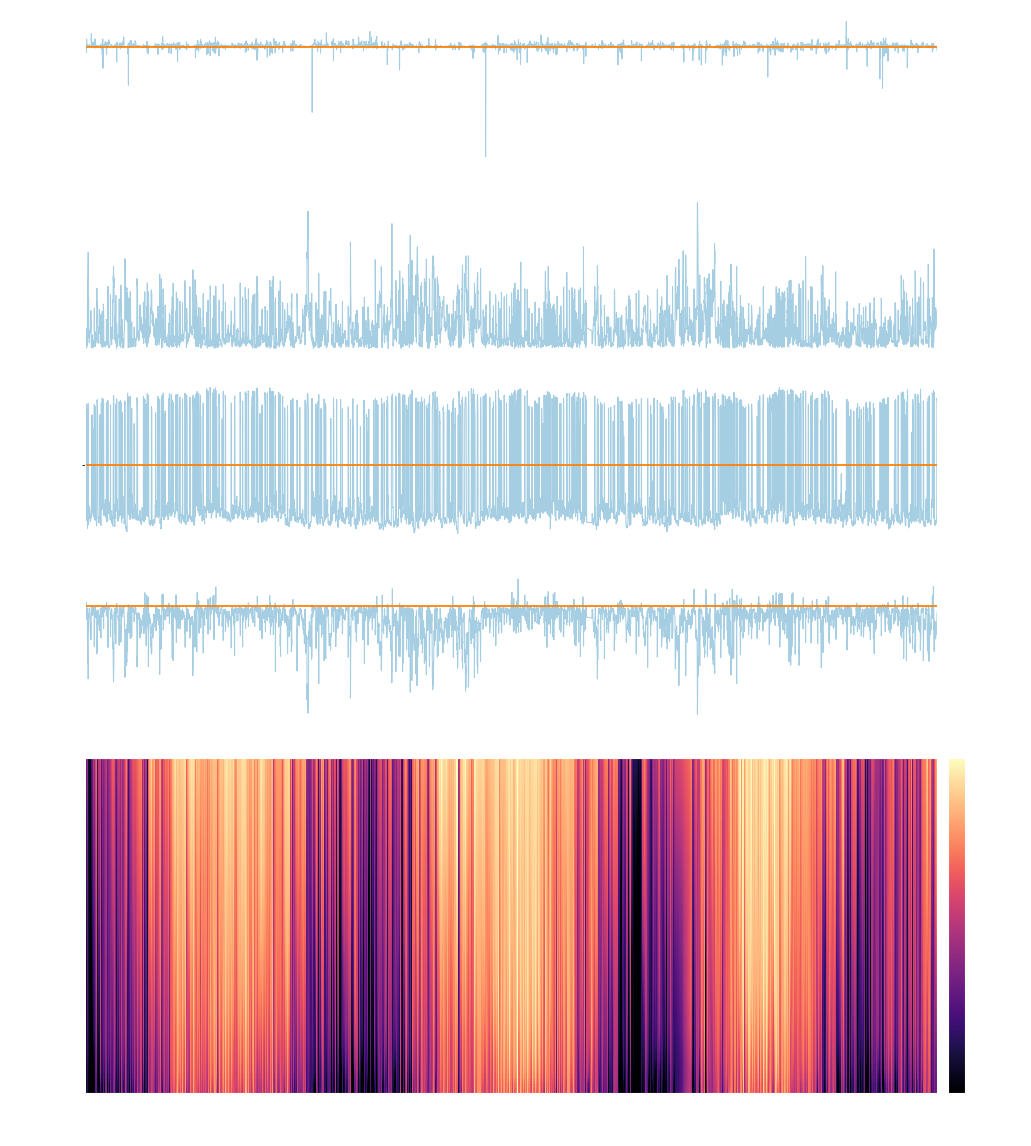

In [100]:
# Plot rectified surface quantities
# --------------------------------------

sb.color_palette("Paired")

fig,ax = plt.subplots(5, 1, figsize = (11, 14), gridspec_kw = {'height_ratios': [1, 1, 1, 1, 2.25]}, sharex = True)

ax[0].plot(range(len(ds_new.time)), ds_new.L, color = sb.color_palette("Paired")[0], linewidth = 0.75)
ax[0].set_ylabel("$1/L$ [m$^{-1}$]", labelpad = 6, color = 'w')
ax[0].axhline(y = 0, color = sb.color_palette("Paired")[7], linestyle = '-', linewidth = 1.25)
ax[0].set_yscale('symlog')
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax[1].plot(range(len(ds_new.time)), ds_new.TKE, color = sb.color_palette("Paired")[0], linewidth = 0.75)
ax[1].set_ylabel("TKE [m$^2$ s$^{-2}$]", labelpad = 26, color = 'w')
ax[1].set_ylim([0, 8])

ax[2].plot(range(len(ds_new.time)), ds_new.hFlux, color = sb.color_palette("Paired")[0], linewidth = 0.75)
ax[2].set_ylabel("Heat flux [W m$^{-2}$]", labelpad = 8, color = 'w')
ax[2].axhline(y = 0, color = sb.color_palette("Paired")[7], linestyle = '-', linewidth = 1.25)
ax[2].set_yscale('symlog')
ax[2].set_yticks([-100, -10, -1, 1, 10, 100])
ax[2].yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

ax[3].plot(range(len(ds_new.time)), ds_new.mFlux, color = sb.color_palette("Paired")[0], linewidth = 0.75)
ax[3].set_ylabel("Mom. flux [kg m$^{-1}$ s$^{-2}$]", labelpad = 4, color = 'w')
ax[3].axhline(y = 0, color = sb.color_palette("Paired")[7], linestyle = '-', linewidth = 1.25)
ax[3].set_yscale('symlog')
ax[3].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

cntf = ax[4].pcolormesh(range(len(ds_new.time)), ds_new.height, ds_new.t, vmin = 280, vmax = 320, cmap = 'magma')
ax[4].set_xlabel("Profile index [-]", color = 'w')
ax[4].set_ylabel("$z$ [m]", labelpad = 8, color = 'w')
ax[4].set_ylim([0, 2000])

cb_ax = fig.add_axes([0.91, 0.11, 0.015, 0.239])
cbar = fig.colorbar(cntf, orientation = 'vertical', cax = cb_ax)
cbar.set_label('Wind speed [m/s]', rotation = 270, labelpad = 15, color = 'w')
cbar.outline.set_color('white')
cbar.ax.yaxis.set_tick_params(color = 'w')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color = 'w')

for spine in ax[0].spines.values():
    spine.set_edgecolor('w')
for spine in ax[1].spines.values():
    spine.set_edgecolor('w')
for spine in ax[2].spines.values():
    spine.set_edgecolor('w')
for spine in ax[3].spines.values():
    spine.set_edgecolor('w')
for spine in ax[4].spines.values():
    spine.set_edgecolor('w')

ax[0].tick_params(axis = 'x', colors = 'w')
ax[0].tick_params(axis = 'y', colors = 'w')
ax[1].tick_params(axis = 'x', colors = 'w')
ax[1].tick_params(axis = 'y', colors = 'w')
ax[2].tick_params(axis = 'x', colors = 'w')
ax[2].tick_params(axis = 'y', colors = 'w')
ax[3].tick_params(axis = 'x', colors = 'w')
ax[3].tick_params(axis = 'y', colors = 'w')
ax[4].tick_params(axis = 'x', colors = 'w')
ax[4].tick_params(axis = 'y', colors = 'w')

plt.savefig('./temp_train_set.png', dpi = 800, bbox_inches = 'tight', transparent = True)

Text(0.5, 1.0, 'Days from reference: 10.54')

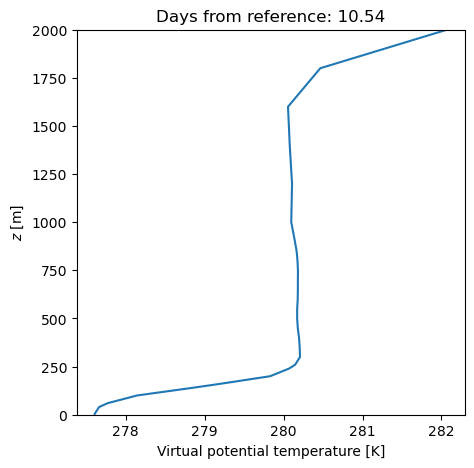

In [27]:
# Plot sample temp profiles
# --------------------------------------

fig,ax = plt.subplots(figsize = (5, 5))

i = 53

ax.plot(ds_new.t[:, i], ds_new.height)
ax.set_xlabel('Virtual potential temperature [K]')
ax.set_ylabel('$z$ [m]')
ax.set_ylim([0, 2000])
ax.set_title('Days from reference: ' + str(round(float(ds_new.time[i].values), 2)))

In [28]:
# Compute common time axis and cyclical time variables
# --------------------------------------

new_ref_times = np.empty(ds_new.time.shape, dtype = 'datetime64[ns]')
hr_per_day    = np.zeros(new_ref_times.shape)
day_per_yr    = np.zeros(new_ref_times.shape)
times         = ds_new.time.values

for i in range(ds_new.time.shape[0]):
    new_ref_times[i] = np.datetime64((pd.Timestamp(ref_date1) + pd.Timedelta(times[i], 'D')).round('min'))
    hr_per_day[i]    = pd.Timestamp(new_ref_times[i]).hour + pd.Timestamp(new_ref_times[i]).minute / 60
    day_per_yr[i]    = new_ref_times[i].astype('datetime64[D]').astype(datetime).timetuple().tm_yday

Text(0, 0.5, 'Day of year')

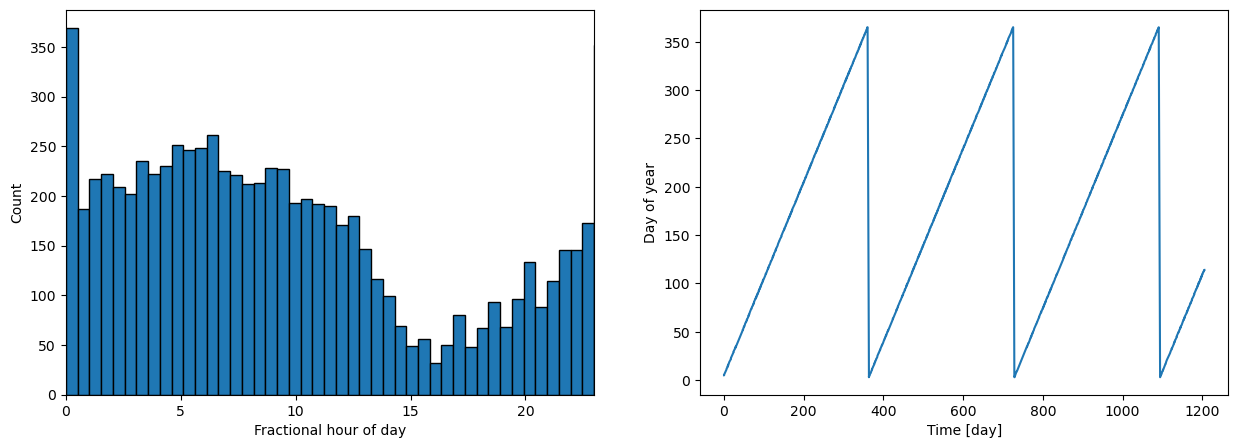

In [29]:
# Confirm time axes are correct
# --------------------------------------

fig,ax = plt.subplots(1, 2, figsize = (15, 5))

ax[0].hist(hr_per_day, bins = 46, edgecolor = 'black')
ax[0].set_xlim([0, 23])
ax[0].set_xlabel('Fractional hour of day')
ax[0].set_ylabel('Count')

ax[1].plot(times, day_per_yr)
ax[1].set_xlabel('Time [day]')
ax[1].set_ylabel('Day of year')

In [30]:
# Save data
# --------------------------------------

ds_new['hr_day'] = (('time'), hr_per_day)
ds_new['day_yr'] = (('time'), day_per_yr)

ds_new.to_netcdf('/Users/smata/Downloads/processedData/temperatureData_30min_diffusion.nc')

ds_new

<xarray.Dataset>
Dimensions:  (height: 102, time: 7771)
Coordinates:
  * height   (height) int64 4 10 20 40 60 80 ... 1900 1920 1940 1960 1980 2000
  * time     (time) float64 0.6458 0.8958 0.9167 ... 1.205e+03 1.205e+03
Data variables:
    t        (height, time) float64 280.8 289.6 289.1 ... 309.7 305.7 305.7
    L        (time) float64 0.01233 0.01038 0.008741 ... -0.04301 -0.06626
    TKE      (time) float64 0.8608 0.7082 0.7116 0.5962 ... 2.057 1.296 1.141
    hFlux    (time) float64 -53.98 -21.49 -28.51 -24.31 ... 102.4 140.6 108.1
    mFlux    (time) float64 -0.1671 -0.0993 -0.1345 ... -0.2702 -0.1317 -0.08525
    hr_day   (time) float64 15.5 21.5 22.0 22.5 23.0 ... 12.5 14.5 22.5 23.0
    day_yr   (time) float64 5.0 5.0 5.0 5.0 5.0 ... 114.0 114.0 114.0 114.0

Text(0, 0.5, 'Time [day]')

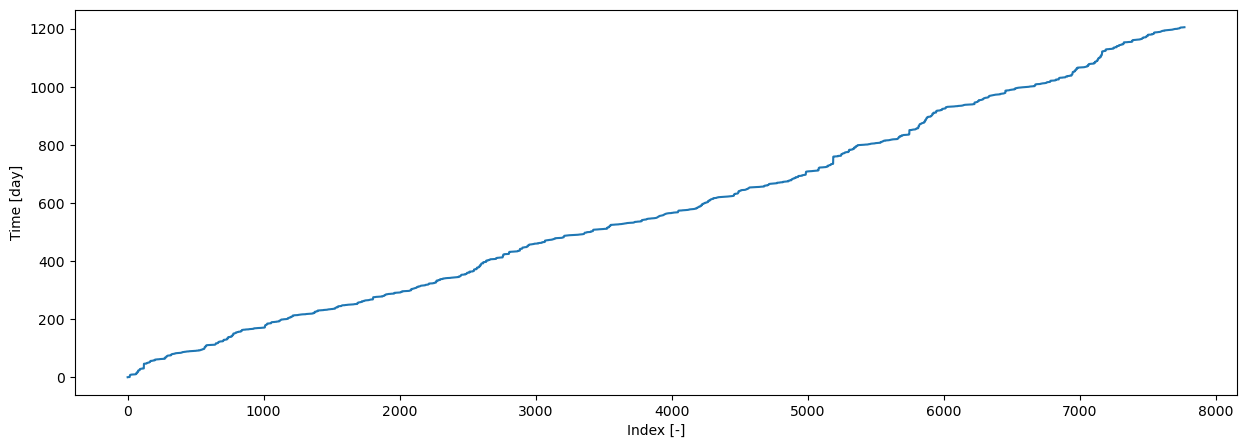

In [33]:
fig,ax = plt.subplots(figsize = (15, 5))

ax.plot(range(len(ds_new.time.values)), ds_new.time.values)
ax.set_xlabel('Profile index [-]')
ax.set_ylabel('Days from regerence [-]')